# Imports

In [15]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import statsmodels.api as sm
import statsmodels.formula.api as smf

sns.set(style="whitegrid", palette="muted", font_scale=1.1)


# Load dataset

In [16]:
df = pd.read_csv("../data/processed/municipalities_connectivity_processed.csv")
df.head()

,year,state,state_name,municipality_id,municipality_name,ibc,coverage_4g5g,fibra,density_smp,hhi_smp,density_scm,hhi_scm,stations_density,region,fiber_cat,ibc_decile
0,2024,RO,Rondônia,1100296,Santa Luzia D'Oeste,49.92,62.9831,100,44.00,51,23.87,47,25.39,N,full,5
1,2024,AC,Acre,1200351,Marechal Thaumaturgo,16.28,30.3470,0,36.72,16,8.04,33,8.36,N,none,1
2,2024,AM,Amazonas,1300839,Caapiranga,29.17,50.9133,50,26.62,7,0.65,71,17.47,N,partial,1
3,2024,AM,Amazonas,1302207,Juruá,20.06,53.3310,0,36.33,36,5.85,19,13.45,N,none,1
4,2024,PA,Pará,1501204,Baião,34.08,52.8200,100,20.46,15,2.85,52,6.26,N,full,2


In [17]:
df.columns

Index(['year', 'state', 'state_name', 'municipality_id', 'municipality_name',
       'ibc', 'coverage_4g5g', 'fibra', 'density_smp', 'hhi_smp',
       'density_scm', 'hhi_scm', 'stations_density', 'region', 'fiber_cat',
       'ibc_decile'],
      dtype='object')

# Remove rows with missing key predictors

In [18]:
model_df = df.dropna(subset=[
    "ibc",
    "coverage_4g5g",
    "density_smp",
    "density_scm",
    "hhi_smp",
    "hhi_scm",
    "stations_density",
    "fiber_cat",
    "region",
    "year"
])
len(model_df)

22280

# Define formula

In [19]:
formula = """
ibc ~ coverage_4g5g
    + density_smp
    + density_scm
    + hhi_smp
    + hhi_scm
    + stations_density
    + C(fiber_cat)
    + C(region)
    + C(year)
"""


# Fit model

In [20]:
model = smf.ols(formula=formula, data=model_df).fit(cov_type="HC3")
model

# Show summary

In [21]:
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                    ibc   R-squared:                       0.982
Model:                            OLS   Adj. R-squared:                  0.982
Method:                 Least Squares   F-statistic:                 1.139e+05
Date:                Tue, 25 Nov 2025   Prob (F-statistic):               0.00
Time:                        18:33:22   Log-Likelihood:                -45218.
No. Observations:               22280   AIC:                         9.047e+04
Df Residuals:                   22264   BIC:                         9.060e+04
Df Model:                          15                                         
Covariance Type:                  HC3                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

# Extract coefficients with interpretation table

In [22]:
results = pd.DataFrame({
    "variable": model.params.index,
    "coef": model.params.values,
    "p_value": model.pvalues.values
})
results

,variable,coef,p_value
0,Intercept,17.321500,0.000000e+00
1,C(fiber_cat)[T.none],-19.006728,0.000000e+00
2,C(fiber_cat)[T.partial],-8.634486,0.000000e+00
3,C(region)[T.N],0.069182,3.735042e-01
4,C(region)[T.NE],0.916619,6.981290e-52
5,C(region)[T.S],1.248453,2.689647e-86
6,C(region)[T.SE],1.048442,7.201090e-65
7,C(year)[T.2022],0.113268,5.018637e-11
8,C(year)[T.2023],0.000180,9.912316e-01
9,C(year)[T.2024],0.523906,4.985870e-13


# Sort by absolute impact

In [23]:
results_sorted = results.sort_values(by="coef", key=lambda x: abs(x), ascending=False)
results_sorted

,variable,coef,p_value
1,C(fiber_cat)[T.none],-19.006728,0.000000e+00
0,Intercept,17.321500,0.000000e+00
2,C(fiber_cat)[T.partial],-8.634486,0.000000e+00
5,C(region)[T.S],1.248453,2.689647e-86
6,C(region)[T.SE],1.048442,7.201090e-65
4,C(region)[T.NE],0.916619,6.981290e-52
9,C(year)[T.2024],0.523906,4.985870e-13
10,coverage_4g5g,0.195982,0.000000e+00
11,density_smp,0.178897,0.000000e+00
12,density_scm,0.157739,0.000000e+00


# Filter only significant variables (p < 0.05)

In [24]:
significant_vars = results[results["p_value"] < 0.05]
significant_vars

,variable,coef,p_value
0,Intercept,17.321500,0.000000e+00
1,C(fiber_cat)[T.none],-19.006728,0.000000e+00
2,C(fiber_cat)[T.partial],-8.634486,0.000000e+00
4,C(region)[T.NE],0.916619,6.981290e-52
5,C(region)[T.S],1.248453,2.689647e-86
6,C(region)[T.SE],1.048442,7.201090e-65
7,C(year)[T.2022],0.113268,5.018637e-11
9,C(year)[T.2024],0.523906,4.985870e-13
10,coverage_4g5g,0.195982,0.000000e+00
11,density_smp,0.178897,0.000000e+00


# Barplot of coefficients

/tmp/ipykernel_30267/474432685.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=results_sorted, y="variable", x="coef", palette="viridis")


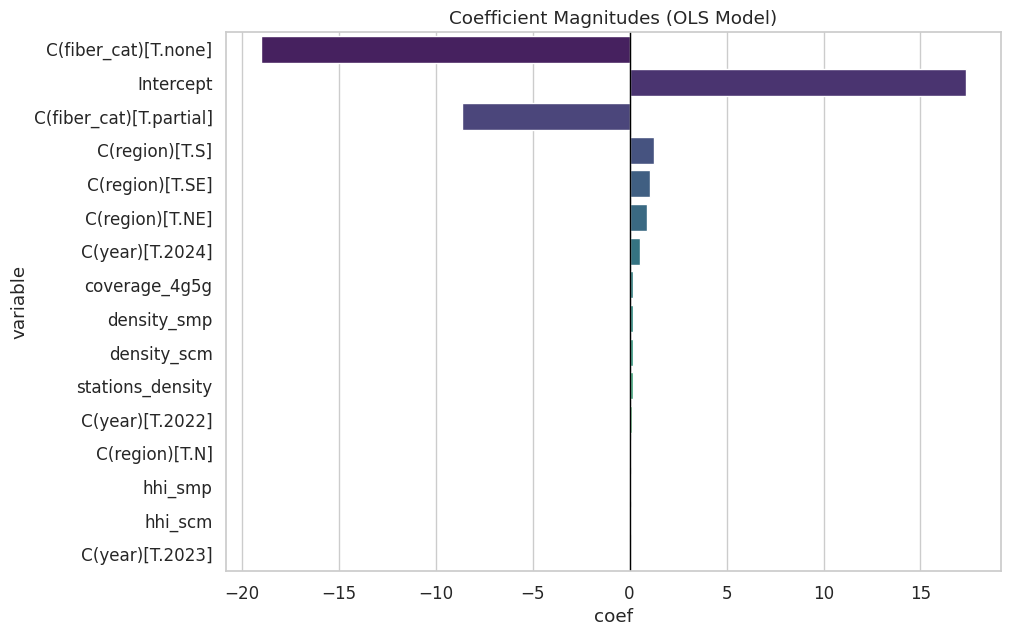

In [25]:
plt.figure(figsize=(10,7))
sns.barplot(data=results_sorted, y="variable", x="coef", palette="viridis")
plt.title("Coefficient Magnitudes (OLS Model)")
plt.axvline(0, color="black", linewidth=1)
plt.show()

# Save regression table

In [26]:
results.to_csv("../reports/figures/regression/regression_coefficients.csv", index=False)

# Save model summary (text)

In [27]:
with open("../reports/paper/regression_summary.txt", "w") as f:
    f.write(model.summary().as_text())